# Model Dev for Detection Issue

## Import

In [28]:
import pandas as pd
from math import isclose
import json
import os
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, StackingClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import dask.dataframe as dd

import geopandas as gpd
from shapely.geometry import Point
import pickle  

# Fonction utils

In [22]:
# Fonction pour charger les données JSON
def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

In [23]:
trafic_df = pd.read_csv("./freq_arret/2013-2021_trafic.csv")
trafic_df


,Rang,Réseau,Station,Trafic,Correspondance_1,Correspondance_2,Correspondance_3,Correspondance_4,Correspondance_5,Ville,Arrondissement pour Paris,Year
0,12,Métro,OPERA,12269711,3,7,8,NaN,NaN,Paris,9.0,2013
1,13,Métro,HOTEL DE VILLE,11953352,1,11,NaN,NaN,NaN,Paris,4.0,2013
2,19,Métro,NATION,9541406,1,2,6,9.0,NaN,Paris,12.0,2013
3,25,Métro,SAINT-MICHEL,8797595,4,NaN,NaN,NaN,NaN,Paris,5.0,2013
4,20,Métro,PALAIS-ROYAL,9385220,1,7,NaN,NaN,NaN,Paris,1.0,2013
...,...,...,...,...,...,...,...,...,...,...,...,...
3320,39,RER,FONTENAY-SOUS-BOIS,2121720,A,NaN,NaN,NaN,NaN,Fontenay-sous-Bois,NaN,2021
3321,40,RER,SUCY-BONNEUIL,1993503,A,NaN,NaN,NaN,NaN,Sucy-en-Brie,NaN,2021
3322,58,RER,LE GUICHET,530706,B,NaN,NaN,NaN,NaN,Orsay,NaN,2021
3323,65,RER,PARC DE SCEAUX,383626,B,NaN,NaN,NaN,NaN,Antony,NaN,2021


In [24]:
df  = pd.read_csv("./freq_arret/arrets.csv" , sep=';')



# Afficher les premières lignes pour vérifier 
df.head()

,ArRId,ArRVersion,ArRCreated,ArRChanged,ArRName,ArRType,ArRPublicCode,ArRXEpsg2154,ArRYEpsg2154,ZdAId,ArRGeopoint,ArRTown,ArRPostalRegion,ArRAccessibility,ArRAudibleSignals,ArRVisualSigns,ArRFareZone
0,14970,1250460-1533057,2014-12-29T00:00:00+01:00,2023-01-09T09:47:08+01:00,Pasteur,bus,-,671805,6843819,42499,"48.693904034797036, 2.61692901241064",Brie-Comte-Robert,77053,partial,unknown,unknown,5
1,14986,1238023-1238017,2014-12-29T00:00:00+01:00,2023-01-09T09:47:08+01:00,Réveillon Écoles,bus,-,670426,6848172,44638,"48.73299424266356, 2.597892392259737",Lésigny,77249,unknown,unknown,unknown,5
2,14987,1238019-1238017,2014-12-29T00:00:00+01:00,2023-01-09T09:47:08+01:00,Réveillon Écoles,bus,-,670418,6848213,44638,"48.73336263308142, 2.5977807812829954",Lésigny,77249,unknown,unknown,unknown,5
3,14954,886152-886163,2014-12-29T00:00:00+01:00,2023-01-09T09:47:08+01:00,Les Myosotis,bus,-,671673,6843457,426937,"48.690646829044304, 2.6151723319505265",Brie-Comte-Robert,77053,partial,unknown,unknown,5
4,14968,1440816-1440818,2014-12-29T15:31:51+01:00,2023-01-09T09:47:08+01:00,Parc Centre Commercial,bus,-,670959,6848670,55149,"48.737497476060646, 2.6051054273842142",Lésigny,77249,unknown,unknown,unknown,5


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38025 entries, 0 to 38024
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ArRId              38025 non-null  int64 
 1   ArRVersion         38025 non-null  object
 2   ArRCreated         37952 non-null  object
 3   ArRChanged         38025 non-null  object
 4   ArRName            38025 non-null  object
 5   ArRType            38025 non-null  object
 6   ArRPublicCode      38025 non-null  object
 7   ArRXEpsg2154       38025 non-null  int64 
 8   ArRYEpsg2154       38025 non-null  int64 
 9   ZdAId              38025 non-null  int64 
 10  ArRGeopoint        38025 non-null  object
 11  ArRTown            38025 non-null  object
 12  ArRPostalRegion    38025 non-null  int64 
 13  ArRAccessibility   38025 non-null  object
 14  ArRAudibleSignals  38025 non-null  object
 15  ArRVisualSigns     38025 non-null  object
 16  ArRFareZone        36087 non-null  objec

#### analyse 

je remarque correlation de nom entre station et ARnam afin de merged les 2 df

In [4]:

# Charger les DataFrames
trafic_df = pd.read_csv("./freq_arret/2013-2021_trafic.csv")
arrets_df = pd.read_csv("./freq_arret/arrets.csv", sep=';')

# Transformer les colonnes 'Station' et 'ArRName' en minuscules
trafic_df['Station'] = trafic_df['Station'].str.lower()
arrets_df['ArRName'] = arrets_df['ArRName'].str.lower()

# Effectuer la jointure sur les colonnes 'Station' et 'ArRName'
merged_df = pd.merge(trafic_df, arrets_df, left_on='Station', right_on='ArRName', how='inner')

# Afficher les premières lignes du DataFrame fusionné pour vérifier
print("Merged DataFrame:")
print(merged_df[['Station', 'ArRName']].head())

# Vérifier quelques valeurs spécifiques
sample_stations = ['opera', 'hotel de ville']  # Par exemple, en minuscules
sample_arrets = merged_df[merged_df['Station'].isin(sample_stations)]
merged_df


Merged DataFrame:
  Station ArRName
0  nation  nation
1  nation  nation
2  nation  nation
3  nation  nation
4  nation  nation


,Rang,Réseau,Station,Trafic,Correspondance_1,Correspondance_2,Correspondance_3,Correspondance_4,Correspondance_5,Ville,...,ArRXEpsg2154,ArRYEpsg2154,ZdAId,ArRGeopoint,ArRTown,ArRPostalRegion,ArRAccessibility,ArRAudibleSignals,ArRVisualSigns,ArRFareZone
0,19,Métro,nation,9541406,1,2,6,9.0,NaN,Paris,...,655661,6861104,462358,"48.84845279706631, 2.3957988351125254",Paris 11e,75111,false,true,true,1
1,19,Métro,nation,9541406,1,2,6,9.0,NaN,Paris,...,655664,6861063,462358,"48.848084289960305, 2.3958439887237373",Paris 12e,75112,false,true,true,1
2,19,Métro,nation,9541406,1,2,6,9.0,NaN,Paris,...,655670,6861104,462358,"48.848453436965976, 2.395925559927623",Paris 11e,75111,false,true,true,1
3,19,Métro,nation,9541406,1,2,6,9.0,NaN,Paris,...,655672,6861152,462358,"48.848885218403474, 2.3959437210498136",Paris 11e,75111,false,true,true,1
4,19,Métro,nation,9541406,1,2,6,9.0,NaN,Paris,...,655671,6861073,473875,"48.84817470172562, 2.3959383298941117",Paris 12e,75112,unknown,unknown,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16487,65,RER,parc de sceaux,383626,B,NaN,NaN,NaN,NaN,Antony,...,649288,6852420,43177,"48.769885381618195, 2.309994431722374",Antony,92002,partial,unknown,unknown,NaN
16488,65,RER,parc de sceaux,383626,B,NaN,NaN,NaN,NaN,Antony,...,648780,6853370,57500,"48.77838909051428, 2.3029672849882807",Sceaux,92071,partial,unknown,unknown,3
16489,65,RER,parc de sceaux,383626,B,NaN,NaN,NaN,NaN,Antony,...,649285,6852383,43177,"48.769552376312525, 2.309956653435713",Antony,92002,unknown,unknown,unknown,3
16490,65,RER,parc de sceaux,383626,B,NaN,NaN,NaN,NaN,Antony,...,649279,6852385,43177,"48.769569891830265, 2.3098747819817276",Antony,92002,unknown,unknown,unknown,3


In [5]:
merged_df.columns

Index(['Rang', 'Réseau', 'Station', 'Trafic', 'Correspondance_1',
       'Correspondance_2', 'Correspondance_3', 'Correspondance_4',
       'Correspondance_5', 'Ville', 'Arrondissement pour Paris', 'Year',
       'ArRId', 'ArRVersion', 'ArRCreated', 'ArRChanged', 'ArRName', 'ArRType',
       'ArRPublicCode', 'ArRXEpsg2154', 'ArRYEpsg2154', 'ZdAId', 'ArRGeopoint',
       'ArRTown', 'ArRPostalRegion', 'ArRAccessibility', 'ArRAudibleSignals',
       'ArRVisualSigns', 'ArRFareZone'],
      dtype='object')

### beaucoup de colonnes inutiles

In [6]:


# Supprimer les colonnes spécifiées
columns_to_drop = [
    'Rang', 'Correspondance_1', 'Correspondance_2', 'Correspondance_3', 
    'Correspondance_4', 'Correspondance_5', 'ArRId', 'ArRVersion', 
    'ArRCreated', 'ArRChanged', 'ArRName', 'ArRType', 'ArRPublicCode', 
    'ArRXEpsg2154', 'ArRYEpsg2154', 'ZdAId', 'ArRTown', 'ArRPostalRegion', 
    'ArRAccessibility', 'ArRAudibleSignals', 'ArRVisualSigns', 'ArRFareZone'
]
merged_df = merged_df.drop(columns=columns_to_drop)

# Afficher les premières lignes du DataFrame fusionné pour vérifier
print("Merged DataFrame sans les colonnes spécifiées:")
print(merged_df.head())

# Vérifier quelques valeurs spécifiques
sample_stations = ['opera', 'hotel de ville']  # Par exemple, en minuscules
sample_arrets = merged_df[merged_df['Station'].isin(sample_stations)]
print("Sample Stations DataFrame:")
print(sample_arrets)

# Enregistrer le DataFrame résultant dans un nouveau fichier CSV
output_file_path = 'final_merged_df_sans_colonnes_specifiees.csv'
merged_df.to_csv(output_file_path, index=False)

print(f"Les DataFrames ont été fusionnés et enregistrés dans {output_file_path}")


Merged DataFrame sans les colonnes spécifiées:
  Réseau Station   Trafic  Ville  Arrondissement pour Paris  Year  \
0  Métro  nation  9541406  Paris                       12.0  2013   
1  Métro  nation  9541406  Paris                       12.0  2013   
2  Métro  nation  9541406  Paris                       12.0  2013   
3  Métro  nation  9541406  Paris                       12.0  2013   
4  Métro  nation  9541406  Paris                       12.0  2013   

                              ArRGeopoint  
0   48.84845279706631, 2.3957988351125254  
1  48.848084289960305, 2.3958439887237373  
2   48.848453436965976, 2.395925559927623  
3  48.848885218403474, 2.3959437210498136  
4   48.84817470172562, 2.3959383298941117  
Sample Stations DataFrame:
Empty DataFrame
Columns: [Réseau, Station, Trafic, Ville, Arrondissement pour Paris, Year, ArRGeopoint]
Index: []
Les DataFrames ont été fusionnés et enregistrés dans final_merged_df_sans_colonnes_specifiees.csv


In [7]:
merged_dff = pd.read_csv('merged_dff.csv')
merged_dff

,Réseau,Station,Trafic,Ville,Arrondissement pour Paris,Year,ArRGeopoint
0,Métro,nation,9541406,Paris,12.0,2013,"48.84845279706631, 2.3957988351125254"
1,Métro,nation,9541406,Paris,12.0,2013,"48.848084289960305, 2.3958439887237373"
2,Métro,nation,9541406,Paris,12.0,2013,"48.848453436965976, 2.395925559927623"
3,Métro,nation,9541406,Paris,12.0,2013,"48.848885218403474, 2.3959437210498136"
4,Métro,nation,9541406,Paris,12.0,2013,"48.84817470172562, 2.3959383298941117"
...,...,...,...,...,...,...,...
16487,RER,parc de sceaux,383626,Antony,NaN,2021,"48.769885381618195, 2.309994431722374"
16488,RER,parc de sceaux,383626,Antony,NaN,2021,"48.77838909051428, 2.3029672849882807"
16489,RER,parc de sceaux,383626,Antony,NaN,2021,"48.769552376312525, 2.309956653435713"
16490,RER,parc de sceaux,383626,Antony,NaN,2021,"48.769569891830265, 2.3098747819817276"


In [8]:
###on clean au maximum le dataset afin de conserver que lessentiel ( on a peu de ressource de compute)

# Line Transport

In [27]:



# Charger les données JSON
file_path = 'traces-du-reseau-ferre-idf.json' 
voie_data = load_json(file_path)

# Extraire les informations des voies à partir du JSON
voies_list = []
for feature in voie_data['features']:
    properties = feature['properties']
    coordinates = feature['geometry']['coordinates']
    voie = {
        'idrefliga': properties['idrefliga'],
        'reseau': properties['reseau'],
        'mode': properties['mode'],
        'res_com': properties['res_com'],
        'coordinates': coordinates
    }
    voies_list.append(voie)

# Convertir en DataFrame
voies_df = pd.DataFrame(voies_list)

# Afficher les premières lignes du DataFrame
voies_df.head()

,idrefliga,reseau,mode,res_com,coordinates
0,A01761,TRAMWAY,TRAMWAY,TRAM 4,"[[2.487910986261173, 48.893094628632376], [2.4..."
1,A01842,RER D,RER,RER D,"[[2.45257339227245, 48.63426831236897], [2.451..."
2,A01842,RER D,RER,RER D,"[[2.435330530181304, 48.64848911258699], [2.43..."
3,A01842,RER D,RER,RER D,"[[2.397532093159732, 48.66791576646778], [2.39..."
4,A01842,RER D,RER,RER D,"[[2.407796286173906, 48.63635136710196], [2.40..."


on a un interer pour les nom de reseau, quon va merge dans notre dataframe

In [26]:


# Charger les DataFrames
merged_df = pd.read_csv("merged_dff.csv")

# Charger le fichier JSON
with open('traces-du-reseau-ferre-idf.json', 'r') as f:
    json_data = json.load(f)

# Extraire les propriétés et les coordonnées du JSON
features = json_data['features']
json_list = []
for feature in features:
    properties = feature['properties']
    coordinates = feature['geometry']['coordinates']
    res_com = properties.get('res_com', None)
    for coord in coordinates:
        properties_filtered = {'coordinate': coord, 'res_com': res_com}
        json_list.append(properties_filtered)

# Convertir la liste en DataFrame
json_df = pd.DataFrame(json_list)

# Convertir les geopoints en objets géométriques Point
merged_df['geometry'] = merged_df['ArRGeopoint'].apply(lambda x: Point(map(float, x.split(','))))
json_df['geometry'] = json_df['coordinate'].apply(lambda x: Point(x[1], x[0]))  # Inverser l'ordre des coordonnées

# Convertir les DataFrames en GeoDataFrames
gdf_merged = gpd.GeoDataFrame(merged_df, geometry='geometry')
gdf_json = gpd.GeoDataFrame(json_df, geometry='geometry')

# Définir la tolérance pour la comparaison des points géographiques
tolerance = 1e-3  # Ajustez cette tolérance selon vos besoins

# Effectuer une jointure spatiale en utilisant sjoin_nearest avec une tolérance
gdf_json.set_crs(epsg=4326, inplace=True)
gdf_merged.set_crs(epsg=4326, inplace=True)

# Ajouter une petite mise en mémoire tampon pour la tolérance
gdf_json['geometry'] = gdf_json['geometry'].buffer(tolerance)

# Effectuer la jointure spatiale
merged_gdf = gpd.sjoin_nearest(gdf_merged, gdf_json, how='left', max_distance=tolerance, distance_col='dist')

# Afficher les colonnes disponibles après la jointure spatiale
print("Colonnes disponibles après la jointure spatiale:")
print(merged_gdf.columns)

# Vérifier si 'res_com' existe et l'ajouter au DataFrame fusionné
if 'res_com' in merged_gdf.columns:
    merged_gdf['res_com'] = merged_gdf['res_com']
elif 'res_com_right' in merged_gdf.columns:
    merged_gdf['res_com'] = merged_gdf['res_com_right']
else:
    print("La colonne 'res_com' n'a pas été trouvée après la jointure.")

# Supprimer les colonnes temporaires et non nécessaires
merged_gdf = merged_gdf.drop(columns=['coordinate', 'geometry', 'dist', 'index_right'])

# Afficher les premières lignes du DataFrame fusionné pour vérifier
print("Final Merged DataFrame:")
print(merged_gdf.head())

# Enregistrer le DataFrame résultant dans un nouveau fichier CSV
output_file_path = 'final_merged_df_with_res_com.csv'
merged_gdf.to_csv(output_file_path, index=False)

print(f"Les DataFrames ont été fusionnés et enregistrés dans {output_file_path}")


C:\Users\SKONIECZNY\AppData\Local\Temp\ipykernel_816\3633532519.py:43: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_json['geometry'] = gdf_json['geometry'].buffer(tolerance)
c:\Users\SKONIECZNY\anaconda3\envs\BigPipe\Lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Colonnes disponibles après la jointure spatiale:
Index(['Réseau', 'Station', 'Trafic', 'Ville', 'Arrondissement pour Paris',
       'Year', 'ArRGeopoint', 'geometry', 'index_right', 'coordinate',
       'res_com', 'dist'],
      dtype='object')
Final Merged DataFrame:
  Réseau Station   Trafic  Ville  Arrondissement pour Paris  Year  \
0  Métro  nation  9541406  Paris                       12.0  2013   
0  Métro  nation  9541406  Paris                       12.0  2013   
0  Métro  nation  9541406  Paris                       12.0  2013   
0  Métro  nation  9541406  Paris                       12.0  2013   
0  Métro  nation  9541406  Paris                       12.0  2013   

                             ArRGeopoint  res_com  
0  48.84845279706631, 2.3957988351125254    RER A  
0  48.84845279706631, 2.3957988351125254  METRO 2  
0  48.84845279706631, 2.3957988351125254  METRO 9  
0  48.84845279706631, 2.3957988351125254  METRO 1  
0  48.84845279706631, 2.3957988351125254  METRO 1  
Les 

In [27]:
df_final = pd.read_csv('final_merged_df_with_res_com.csv')
df_final

,Réseau,Station,Trafic,Ville,Arrondissement pour Paris,Year,ArRGeopoint,res_com
0,Métro,nation,9541406,Paris,12.0,2013,"48.84845279706631, 2.3957988351125254",RER A
1,Métro,nation,9541406,Paris,12.0,2013,"48.84845279706631, 2.3957988351125254",METRO 2
2,Métro,nation,9541406,Paris,12.0,2013,"48.84845279706631, 2.3957988351125254",METRO 9
3,Métro,nation,9541406,Paris,12.0,2013,"48.84845279706631, 2.3957988351125254",METRO 1
4,Métro,nation,9541406,Paris,12.0,2013,"48.84845279706631, 2.3957988351125254",METRO 1
...,...,...,...,...,...,...,...,...
102210,RER,parc de sceaux,383626,Antony,NaN,2021,"48.769569891830265, 2.3098747819817276",RER B
102211,RER,parc de sceaux,383626,Antony,NaN,2021,"48.769569891830265, 2.3098747819817276",RER B
102212,RER,parc de sceaux,383626,Antony,NaN,2021,"48.769569891830265, 2.3098747819817276",RER B
102213,RER,parc de sceaux,383626,Antony,NaN,2021,"48.769569891830265, 2.3098747819817276",RER B


# on va link les coordonnées au dataframe précédent

# on vérife les chantiers travaux


In [28]:
SNCF_df = pd.read_csv('./TravauxSNCF_RATP_2019-2022.csv', sep=';')
SNCF_df

,Référence Chantier,Code postal arrondissement - Commune,Date début du chantier,Date fin du chantier,Responsable du chantier,Maîtrise d'ouvrage principale,Surface (m2),Synthèse - Nature du chantier,Encombrement espace public,Impact stationnement,Identifiant demande CITE,Identifiant Chantier CITE,geo_shape,geo_point_2d
0,EC149360,75004,2019-12-16,2019-12-20,Opérateurs de réseau (gaz-électricité-RATP-etc),RATP,9.13,Travaux sur réseau de transport public,EMPRISE_TROTTOIR,NaN,130520,103482,"{""coordinates"": [[[2.3584960379852222, 48.8543...","48.85431161383518, 2.358496563308432"
1,EC143169,75015,2019-11-25,2019-12-13,Opérateurs de réseau (gaz-électricité-RATP-etc),RATP,224.69,Travaux sur réseau de transport public,"EMPRISE_CHAUSSEE,EMPRISE_TROTTOIR",NaN,124986,98918,"{""coordinates"": [[[2.298130063341984, 48.84908...","48.84904331680768, 2.2979730027487317"
2,EC146035,75017,2019-11-28,2019-12-06,Opérateurs de réseau (gaz-électricité-RATP-etc),SNCF,383.32,Travaux sur réseau de transport public,EMPRISE_CHAUSSEE,NaN,127442,100873,"{""coordinates"": [[[2.294098752608522, 48.87490...","48.875105790329215, 2.2938792856422676"
3,EC101353,75001,2019-03-08,2019-06-28,Opérateurs de réseau (gaz-électricité-RATP-etc),RATP,103.44,Travaux sur réseau de transport public,EMPRISE_TROTTOIR,NaN,87566,67973,"{""coordinates"": [[[[2.342282086238916, 48.8586...","48.85869275120488, 2.3421547092435926"
4,EC6520,75012,2016-01-01,2022-01-25,Opérateurs de réseau (gaz-électricité-RATP-etc),RATP,1760.89,Travaux sur réseau de transport public,EMPRISE_CHAUSSEE,NaN,4037,3079,"{""coordinates"": [[[2.396792756027481, 48.84758...","48.847861582585196, 2.3968969115602876"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2547,EC304653,75015,2022-10-06,2022-11-10,Opérateurs de réseau (gaz-électricité-RATP-etc),RATP,19.28,Travaux sur réseau de transport public,EMPRISE_TROTTOIR,NaN,733881,201349,"{""coordinates"": [[[2.284352185478997, 48.83391...","48.83388082847594, 2.2844072785931644"
2548,EC311629,75014,2022-11-24,2022-12-02,Opérateurs de réseau (gaz-électricité-RATP-etc),RATP,13.96,Travaux sur réseau de transport public,EMPRISE_CHAUSSEE,STATIONNEMENT_PAYANT,767173,205914,"{""coordinates"": [[[2.32495917057641, 48.841083...","48.84106036189037, 2.325000795252847"
2549,EC237774,75012,2021-10-11,2022-06-23,Opérateurs de réseau (gaz-électricité-RATP-etc),RATP,62.40,Travaux sur réseau de transport public,EMPRISE_TROTTOIR,NaN,445439,159992,"{""coordinates"": [[[[2.371750724396233, 48.8447...","48.844776005236575, 2.3717317530274373"
2550,EC302876,75020,2022-11-14,2023-06-08,Opérateurs de réseau (gaz-électricité-RATP-etc),RATP,201.35,Travaux sur réseau de transport public,"EMPRISE_CHAUSSEE,EMPRISE_TROTTOIR",NaN,727404,200226,"{""coordinates"": [[[[2.3963398106706215, 48.854...","48.85388041288721, 2.3964143861956844"


### on va recuperer les voies qui ont deja eu des travaux et merge avec notre dataframe, s'il en adeja eu , on lui accorde 1 , si jamais on lui accorde 0; et si cest reccurent on lui accorde 2

In [35]:

# Charger les DataFrames
df_final = pd.read_csv('final_merged_df_with_res_com.csv')

# Charger le fichier de travaux avec le bon délimiteur
df_travaux = pd.read_csv('TravauxSNCF_RATP_2019-2022.csv', delimiter=';')

# Convertir les coordonnées en objets géométriques Point pour df_final
df_final['geometry'] = df_final['ArRGeopoint'].apply(lambda x: Point(map(float, x.split(','))))

# Extraire les coordonnées de la colonne 'geo_shape' pour df_travaux
def extract_point(geo_shape):
    try:
        if isinstance(geo_shape, str):
            geo_json = json.loads(geo_shape.replace("'", "\""))
            if geo_json['type'] == 'Point':
                return Point(geo_json['coordinates'])
            elif geo_json['type'] == 'LineString':
                # Si c'est une ligne, nous prenons le premier point
                return Point(geo_json['coordinates'][0])
            elif geo_json['type'] == 'Polygon':
                # Si c'est un polygone, nous prenons le premier point du premier anneau
                return Point(geo_json['coordinates'][0][0])
        return None
    except Exception as e:
        print(f"Error parsing geo_shape: {e}")
        return None

df_travaux['geometry'] = df_travaux['geo_shape'].apply(extract_point)

# Filtrer les lignes où la géométrie a été correctement extraite
df_travaux = df_travaux.dropna(subset=['geometry'])

# Convertir les DataFrames en GeoDataFrames
gdf_final = gpd.GeoDataFrame(df_final, geometry='geometry')
gdf_travaux = gpd.GeoDataFrame(df_travaux, geometry='geometry')

# Définir le système de coordonnées
gdf_final.set_crs(epsg=4326, inplace=True)
gdf_travaux.set_crs(epsg=4326, inplace=True)

# Effectuer une jointure spatiale avec tolérance
joined_gdf = gpd.sjoin(gdf_final, gdf_travaux, how='left', predicate='intersects')

# Créer une nouvelle colonne `travaux` et initialiser à 0
joined_gdf['travaux'] = 0

# Mettre à jour la colonne `travaux` en fonction des occurrences de travaux
# Compter le nombre de fois qu'une station a eu des travaux
travaux_counts = joined_gdf.groupby(gdf_final.index).size()

# Mettre à jour la colonne `travaux` en fonction du nombre de travaux
for idx, count in travaux_counts.items():
    if count > 1:
        joined_gdf.at[idx, 'travaux'] = 2
    elif count == 1:
        joined_gdf.at[idx, 'travaux'] = 1

# Supprimer les colonnes temporaires et non nécessaires
joined_gdf = joined_gdf.drop(columns=['index_right', 'geometry'])

# # Enregistrer le DataFrame résultant dans un nouveau fichier CSV
# output_file_path = 'final_merged_df_with_travaux.csv'
# joined_gdf.to_csv(output_file_path, index=False)

# print(f"Les DataFrames ont été fusionnés et enregistrés dans {output_file_path}")

joined_gdf

,Réseau,Station,Trafic,Ville,Arrondissement pour Paris,Year,ArRGeopoint,res_com,Référence Chantier,Code postal arrondissement - Commune,...,Maîtrise d'ouvrage principale,Surface (m2),Synthèse - Nature du chantier,Encombrement espace public,Impact stationnement,Identifiant demande CITE,Identifiant Chantier CITE,geo_shape,geo_point_2d,travaux
0,Métro,nation,9541406,Paris,12.0,2013,"48.84845279706631, 2.3957988351125254",RER A,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,Métro,nation,9541406,Paris,12.0,2013,"48.84845279706631, 2.3957988351125254",METRO 2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,Métro,nation,9541406,Paris,12.0,2013,"48.84845279706631, 2.3957988351125254",METRO 9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,Métro,nation,9541406,Paris,12.0,2013,"48.84845279706631, 2.3957988351125254",METRO 1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,Métro,nation,9541406,Paris,12.0,2013,"48.84845279706631, 2.3957988351125254",METRO 1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102210,RER,parc de sceaux,383626,Antony,NaN,2021,"48.769569891830265, 2.3098747819817276",RER B,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
102211,RER,parc de sceaux,383626,Antony,NaN,2021,"48.769569891830265, 2.3098747819817276",RER B,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
102212,RER,parc de sceaux,383626,Antony,NaN,2021,"48.769569891830265, 2.3098747819817276",RER B,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
102213,RER,parc de sceaux,383626,Antony,NaN,2021,"48.769569891830265, 2.3098747819817276",RER B,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


### observation

On a récupéré les travaux, on va pouvoir supprimer les colonnes inutiles

In [36]:
joined_gdf.columns

Index(['Réseau', 'Station', 'Trafic', 'Ville', 'Arrondissement pour Paris',
       'Year', 'ArRGeopoint', 'res_com', 'Référence Chantier',
       'Code postal arrondissement - Commune', 'Date début du chantier',
       'Date fin du chantier', 'Responsable du chantier',
       'Maîtrise d'ouvrage principale', 'Surface (m2)',
       'Synthèse - Nature du chantier', 'Encombrement espace public',
       'Impact stationnement', 'Identifiant demande CITE',
       'Identifiant Chantier CITE', 'geo_shape', 'geo_point_2d', 'travaux'],
      dtype='object')

In [37]:
# Supprimer les colonnes spécifiées
colonnes_a_supprimer = ['Référence Chantier',
       'Code postal arrondissement - Commune', 'Date début du chantier',
       'Date fin du chantier', 'Responsable du chantier',
       "Maîtrise d'ouvrage principale", 'Surface (m2)',
       'Synthèse - Nature du chantier', 'Encombrement espace public',
       'Impact stationnement', 'Identifiant demande CITE',
       'Identifiant Chantier CITE', 'geo_shape', 'geo_point_2d']

joined_gdf = joined_gdf.drop(columns=colonnes_a_supprimer)

# Enregistrer le DataFrame résultant dans un nouveau fichier CSV
output_file_path = 'final_merged_df_with_travaux.csv'
joined_gdf.to_csv(output_file_path, index=False)

print(f"Les DataFrames ont été fusionnés, les colonnes spécifiées ont été supprimées, et le résultat a été enregistré dans {output_file_path}")

Les DataFrames ont été fusionnés, les colonnes spécifiées ont été supprimées, et le résultat a été enregistré dans final_merged_df_with_travaux.csv


## NB Fer

In [65]:

# Chemins des fichiers CSV
file_paths = [
    r"C:\Users\SKONIECZNY\Desktop\Transport_App\ML_module\data_model\validation\merged_NB_FER.csv\part-00112-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv",
    r"C:\Users\SKONIECZNY\Desktop\Transport_App\ML_module\data_model\validation\merged_NB_FER.csv\part-00113-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv",
    r"C:\Users\SKONIECZNY\Desktop\Transport_App\ML_module\data_model\validation\merged_NB_FER.csv\part-00114-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv",
    r"C:\Users\SKONIECZNY\Desktop\Transport_App\ML_module\data_model\validation\merged_NB_FER.csv\part-00115-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv",
    r"C:\Users\SKONIECZNY\Desktop\Transport_App\ML_module\data_model\validation\merged_NB_FER.csv\part-00116-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv",
    r"C:\Users\SKONIECZNY\Desktop\Transport_App\ML_module\data_model\validation\merged_NB_FER.csv\part-00117-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv",
    r"C:\Users\SKONIECZNY\Desktop\Transport_App\ML_module\data_model\validation\merged_NB_FER.csv\part-00118-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv",
    r"C:\Users\SKONIECZNY\Desktop\Transport_App\ML_module\data_model\validation\merged_NB_FER.csv\part-00119-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv"
]

# Initialiser une liste pour stocker les DataFrames
dataframes = []

# Lire les fichiers CSV
for file_path in file_paths:
    df = pd.read_csv(file_path, delimiter=',')
    dataframes.append(df)

# Concaténer tous les DataFrames en un seul
df_concat = pd.concat(dataframes, ignore_index=True)

# Afficher les premières lignes du DataFrame concaténé pour vérifier
print(df_concat.head())

         JOUR  CODE_STIF_TRNS CODE_STIF_RES CODE_STIF_ARRET  LIBELLE_ARRET  \
0  01/07/2022             100           110               1  PORTE MAILLOT   
1  01/07/2022             100           110               1  PORTE MAILLOT   
2  01/07/2022             100           110               1  PORTE MAILLOT   
3  01/07/2022             100           110               1  PORTE MAILLOT   
4  01/07/2022             100           110               1  PORTE MAILLOT   

   ID_REFA_LDA CATEGORIE_TITRE  NB_VALD  date  
0        71379               ?      253  2022  
1        71379       AMETHYSTE      171  2022  
2        71379     AUTRE TITRE     1398  2022  
3        71379             FGT      247  2022  
4        71379       IMAGINE R     2510  2022  


#### pourquoi seulement quelques un

les données sont volumineuses et je n'ai pas les ressources afin de développer avec plus

In [67]:
df_concat.columns

Index(['JOUR', 'CODE_STIF_TRNS', 'CODE_STIF_RES', 'CODE_STIF_ARRET',
       'LIBELLE_ARRET', 'ID_REFA_LDA', 'CATEGORIE_TITRE', 'NB_VALD', 'date'],
      dtype='object')

## on cherche à voir laffluence des stations

pour cela nous conserverons seuleemnt les nombre de validation par jour , ferons laggregations par jour / mois et qualiefirons les stations à grande inffluence

In [70]:
# Supprimer les colonnes spécifiées
columns_to_drop = ['CODE_STIF_TRNS', 'CODE_STIF_RES', 'CODE_STIF_ARRET', 'ID_REFA_LDA', 'CATEGORIE_TITRE', 'date']
df_concat.drop(columns=columns_to_drop, inplace=True)

# Afficher les premières lignes du DataFrame concaténé pour vérifier
print(df_concat.head())

KeyError: "['CODE_STIF_TRNS', 'CODE_STIF_RES', 'CODE_STIF_ARRET', 'ID_REFA_LDA', 'CATEGORIE_TITRE', 'date'] not found in axis"

In [71]:
df_concat

,JOUR,LIBELLE_ARRET,NB_VALD
0,01/07/2022,PORTE MAILLOT,253
1,01/07/2022,PORTE MAILLOT,171
2,01/07/2022,PORTE MAILLOT,1398
3,01/07/2022,PORTE MAILLOT,247
4,01/07/2022,PORTE MAILLOT,2510
...,...,...,...
1105942,31/12/2022,VILLEPINTE,212
1105943,31/12/2022,VILLEPINTE,614
1105944,31/12/2022,VILLEPINTE,6
1105945,31/12/2022,VILLEPINTE,6


l'objectif est de calculer l'affluence , alors on va regrouper par jour chaque arret et determiner l'affluence total de la journée

In [73]:
# Convertir les dates en datetime si nécessaire
df_concat['JOUR'] = pd.to_datetime(df_concat['JOUR'], format='%d/%m/%Y', errors='coerce')

# Convertir les noms de stations en minuscules pour une correspondance uniforme
df_concat['LIBELLE_ARRET'] = df_concat['LIBELLE_ARRET'].str.lower()

# Grouper par JOUR et LIBELLE_ARRET, puis sommer les valeurs de NB_VALD
df_grouped = df_concat.groupby(['JOUR', 'LIBELLE_ARRET'], as_index=False).agg({'NB_VALD': 'sum'})

In [74]:
df_grouped

,JOUR,LIBELLE_ARRET,NB_VALD
0,2022-07-01,abbesses,4011
1,2022-07-01,ablon,1099
2,2022-07-01,acheres grand,53
3,2022-07-01,acheres ville,4009
4,2022-07-01,aeroport cdg1,5269
...,...,...,...
135734,2022-12-31,voltaire,4305
135735,2022-12-31,vulaines sur se,23
135736,2022-12-31,wagram,1395
135737,2022-12-31,yerres,1546


on peut alors merge nos dataframes

In [77]:
df_final = pd.read_csv('final_merged_df_with_travaux.csv')

# Fusionner les deux DataFrames
merged_df = pd.merge(df_final, df_grouped, left_on='Station', right_on='LIBELLE_ARRET', how='left')

# Afficher les premières lignes du DataFrame fusionné pour vérifier
print("Merged DataFrame:")
print(merged_df.head())

Merged DataFrame:
  Réseau Station   Trafic  Ville  Arrondissement pour Paris  Year  \
0  Métro  nation  9541406  Paris                       12.0  2013   
1  Métro  nation  9541406  Paris                       12.0  2013   
2  Métro  nation  9541406  Paris                       12.0  2013   
3  Métro  nation  9541406  Paris                       12.0  2013   
4  Métro  nation  9541406  Paris                       12.0  2013   

                             ArRGeopoint res_com  travaux       JOUR  \
0  48.84845279706631, 2.3957988351125254   RER A        1 2022-07-01   
1  48.84845279706631, 2.3957988351125254   RER A        1 2022-07-02   
2  48.84845279706631, 2.3957988351125254   RER A        1 2022-07-03   
3  48.84845279706631, 2.3957988351125254   RER A        1 2022-07-04   
4  48.84845279706631, 2.3957988351125254   RER A        1 2022-07-05   

  LIBELLE_ARRET  NB_VALD  
0        nation  32686.0  
1        nation  24486.0  
2        nation  17702.0  
3        nation  31065.0  

In [78]:
merged_df.columns

Index(['Réseau', 'Station', 'Trafic', 'Ville', 'Arrondissement pour Paris',
       'Year', 'ArRGeopoint', 'res_com', 'travaux', 'JOUR', 'LIBELLE_ARRET',
       'NB_VALD'],
      dtype='object')

In [81]:
output_file_path = 'df_nb_valid_trav_res.csv'
merged_df.to_csv(output_file_path, index=False)

print(f"Le DataFrame groupé a été enregistré dans {output_file_path}")

Le DataFrame groupé a été enregistré dans df_nb_valid_trav_res.csv


### Il manque juste la météo

In [8]:
weather_df = pd.read_csv('./all_weather/2023-2024-weather_cleaned.csv')
weather_df

,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI_x,AAAAMMJJ,PMERM,QPMERM,PMERMIN,QPMERMIN,...,QFXI,DXI,QDXI,HXI,QHXI,FXI3S,QFXI3S,QDXI3S,HXI3S,QHXI3S
0,75106001,LUXEMBOURG,48.844667,2.333833,46.0,20230101,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,75107005,TOUR EIFFEL,48.858333,2.294500,330.0,20230101,NaN,NaN,NaN,NaN,...,1.0,210.0,9.0,2004.0,9.0,23.2,9.0,NaN,2206.0,9.0
2,75110001,LARIBOISIERE,48.882833,2.352000,55.0,20230101,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,75112004,ST-ANTOINE,48.848167,2.380833,NaN,20230101,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,75114001,PARIS-MONTSOURIS,48.821667,2.337833,75.0,20230101,1014.9,1.0,1012.2,1.0,...,1.0,220.0,1.0,37.0,9.0,13.5,1.0,NaN,58.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2961,75107005,TOUR EIFFEL,48.858333,2.294500,330.0,20240428,NaN,NaN,NaN,NaN,...,1.0,190.0,1.0,244.0,9.0,19.9,1.0,NaN,244.0,9.0
2962,75110001,LARIBOISIERE,48.882833,2.352000,55.0,20240428,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2963,75114001,PARIS-MONTSOURIS,48.821667,2.337833,75.0,20240428,1010.8,1.0,1001.4,1.0,...,1.0,220.0,1.0,752.0,9.0,12.7,1.0,NaN,752.0,9.0
2964,75114007,PARIS-MONTSOURIS-DOUBLE,48.821667,2.337833,75.0,20240428,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
weather_df.columns

Index(['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON', 'ALTI_x', 'AAAAMMJJ', 'PMERM',
       'QPMERM', 'PMERMIN', 'QPMERMIN', 'INST', 'QINST', 'GLOT', 'QGLOT',
       'SIGMA', 'QSIGMA', 'UN', 'QUN', 'HUN', 'QHUN', 'UX', 'QUX', 'HUX',
       'QHUX', 'UM', 'QUM', 'DHUMI40', 'QDHUMI40', 'DHUMI80', 'QDHUMI80',
       'TSVM', 'QTSVM', 'ETPMON', 'QETPMON', 'ETPGRILLE', 'QETPGRILLE',
       'NEIGETOTX', 'QNEIGETOTX', 'NEIGETOT06', 'QNEIGETOT06', 'NEIG', 'QNEIG',
       'BROU', 'QBROU', 'GELEE', 'QGELEE', 'FUMEE', 'QFUMEE', 'BRUME',
       'QBRUME', 'ALTI_y', 'RR', 'QRR', 'TN', 'QTN', 'HTN', 'QHTN', 'TX',
       'QTX', 'HTX', 'QHTX', 'TM', 'QTM', 'TNTXM', 'QTNTXM', 'TAMPLI',
       'QTAMPLI', 'TNSOL', 'QTNSOL', 'TN50', 'QTN50', 'DG', 'QDG', 'FFM',
       'QFFM', 'FXY', 'QFXY', 'DXY', 'QDXY', 'HXY', 'QHXY', 'FXI', 'QFXI',
       'DXI', 'QDXI', 'HXI', 'QHXI', 'FXI3S', 'QFXI3S', 'QDXI3S', 'HXI3S',
       'QHXI3S'],
      dtype='object')

In [4]:
# Ajouter des valeurs à la colonne 'travaux' avec les proportions spécifiées
proportions_travaux = [0.6, 0.2, 0.2]
travaux_values = [0, 1, 2]

df['travaux'] = np.random.choice(travaux_values, size=len(df), p=proportions_travaux)

# Vérifier la distribution des valeurs dans la colonne 'travaux'
print(df['travaux'].value_counts(normalize=True))

0    0.600033
1    0.200060
2    0.199907
Name: travaux, dtype: float64


je garde ceux qui ont le plus d'impact : 


PMERM - Mean precipitation
TN - Minimum temperature
HTX - High temperature
RR - Rainfall
NEIG - Snow
GELEE - Frost
BROU - Mist


In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import gc

# Function to process each chunk
def process_chunk(chunk):
    # Convert to GeoDataFrame
    chunk['geometry'] = chunk['ArRGeopoint'].apply(lambda x: Point(map(float, x.split(','))))
    gdf_chunk = gpd.GeoDataFrame(chunk, geometry='geometry')
    return gdf_chunk

# Function to read and process chunks of the main CSV file
def read_and_process_chunks(file_path, chunk_size=10000):
    gdf_chunks = []
    for chunk in pd.read_csv(file_path, chunksize=chunk_size, dtype={
        'Réseau': 'category', 'Station': 'category', 'Trafic': 'float32', 
        'Ville': 'category', 'Arrondissement pour Paris': 'category', 
        'Year': 'int16', 'ArRGeopoint': 'object', 'res_com': 'category', 
        'travaux': 'category', 'JOUR': 'category', 'LIBELLE_ARRET': 'category', 
        'NB_VALD': 'float32'}):  # Change to float32 to avoid conversion issues
        gdf_chunk = process_chunk(chunk)
        gdf_chunks.append(gdf_chunk)
        gc.collect()  # Explicitly trigger garbage collection
    return gdf_chunks

# Read the CSV in chunks and process
gdf_chunks = read_and_process_chunks('df_nb_valid_trav_res.csv')

# Concatenate all chunks into a single GeoDataFrame
gdf_merged = pd.concat(gdf_chunks, ignore_index=True)
del gdf_chunks  # Free up memory

# Read and process the weather data
weather_df = pd.read_csv('./all_weather/2023-2024-weather_cleaned.csv', dtype={
    'LON': 'float32', 'LAT': 'float32', 'PMERM': 'float32', 'TX': 'float32', 
    'HTX': 'float32', 'RR': 'float32', 'NEIG': 'category', 'GELEE': 'category', 
    'BROU': 'category'})

weather_df['geometry'] = weather_df.apply(lambda row: Point(row['LON'], row['LAT']), axis=1)
gdf_weather = gpd.GeoDataFrame(weather_df, geometry='geometry')
del weather_df  # Free up memory

# Ensure both GeoDataFrames use the same CRS
gdf_merged.set_crs(epsg=4326, inplace=True)
gdf_weather.set_crs(epsg=4326, inplace=True)

# Define the number of chunks
num_chunks = 1000  # Adjust this number based on your memory capacity

# Split the merged DataFrame into smaller chunks
chunks = np.array_split(gdf_merged, num_chunks)

# List to hold the results
results = []

# Perform spatial join for each chunk
for chunk in chunks:
    joined_chunk = gpd.sjoin_nearest(chunk, gdf_weather, how='left', distance_col='dist')
    results.append(joined_chunk)
    del joined_chunk  # Free up memory
    gc.collect()  # Explicitly trigger garbage collection

# Concatenate all chunks into a single GeoDataFrame
final_gdf = pd.concat(results, ignore_index=True)
del results  # Free up memory

# Select relevant columns from the weather DataFrame to merge
weather_columns = ['PMERM', 'TX', 'HTX', 'RR', 'NEIG', 'GELEE', 'BROU']

# Include weather columns in the final DataFrame
columns_to_keep = ['Réseau', 'Station', 'Trafic', 'Ville', 'Arrondissement pour Paris', 'Year', 
                   'ArRGeopoint', 'res_com', 'travaux', 'JOUR', 'LIBELLE_ARRET', 'NB_VALD'] + weather_columns

final_gdf = final_gdf[columns_to_keep]

# Save the resulting DataFrame to a CSV file
output_file_path = 'final_merged_df_with_weather.csv'
final_gdf.to_csv(output_file_path, index=False)

print(f"The DataFrame has been merged and saved to {output_file_path}")


c:\Users\SKONIECZNY\anaconda3\lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
c:\Users\SKONIECZNY\anaconda3\lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
c:\Users\SKONIECZNY\anaconda3\lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
c:\Users\SKONIECZNY\anaconda3\lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incor

MemoryError: Unable to allocate 234. MiB for an array with shape (80, 383997) and data type float64

In [3]:
df = pd.read_csv('df_nb_valid_trav_res.csv')
df

,Réseau,Station,Trafic,Ville,Arrondissement pour Paris,Year,ArRGeopoint,res_com,travaux,JOUR,LIBELLE_ARRET,NB_VALD
0,Métro,nation,9541406,Paris,12.0,2013,"48.84845279706631, 2.3957988351125254",RER A,1,2022-07-01,nation,32686.0
1,Métro,nation,9541406,Paris,12.0,2013,"48.84845279706631, 2.3957988351125254",RER A,1,2022-07-02,nation,24486.0
2,Métro,nation,9541406,Paris,12.0,2013,"48.84845279706631, 2.3957988351125254",RER A,1,2022-07-03,nation,17702.0
3,Métro,nation,9541406,Paris,12.0,2013,"48.84845279706631, 2.3957988351125254",RER A,1,2022-07-04,nation,31065.0
4,Métro,nation,9541406,Paris,12.0,2013,"48.84845279706631, 2.3957988351125254",RER A,1,2022-07-05,nation,33351.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12386664,RER,parc de sceaux,383626,Antony,NaN,2021,"48.77799168105732, 2.304224607617893",RER B,1,2022-12-27,parc de sceaux,734.0
12386665,RER,parc de sceaux,383626,Antony,NaN,2021,"48.77799168105732, 2.304224607617893",RER B,1,2022-12-28,parc de sceaux,704.0
12386666,RER,parc de sceaux,383626,Antony,NaN,2021,"48.77799168105732, 2.304224607617893",RER B,1,2022-12-29,parc de sceaux,769.0
12386667,RER,parc de sceaux,383626,Antony,NaN,2021,"48.77799168105732, 2.304224607617893",RER B,1,2022-12-30,parc de sceaux,645.0


## EDA 

In [5]:
df.info

<bound method DataFrame.info of          Réseau         Station   Trafic   Ville  Arrondissement pour Paris  \
0         Métro          nation  9541406   Paris                       12.0   
1         Métro          nation  9541406   Paris                       12.0   
2         Métro          nation  9541406   Paris                       12.0   
3         Métro          nation  9541406   Paris                       12.0   
4         Métro          nation  9541406   Paris                       12.0   
...         ...             ...      ...     ...                        ...   
12386664    RER  parc de sceaux   383626  Antony                        NaN   
12386665    RER  parc de sceaux   383626  Antony                        NaN   
12386666    RER  parc de sceaux   383626  Antony                        NaN   
12386667    RER  parc de sceaux   383626  Antony                        NaN   
12386668    RER  parc de sceaux   383626  Antony                        NaN   

          Year     

In [6]:

# Pour un affichage plus lisible, vous pouvez utiliser une boucle pour lister les colonnes par type
for col in df.columns:
    print(f"Colonne: {col}, Type: {df[col].dtype}")

Colonne: Réseau, Type: object
Colonne: Station, Type: object
Colonne: Trafic, Type: int64
Colonne: Ville, Type: object
Colonne: Arrondissement pour Paris, Type: float64
Colonne: Year, Type: int64
Colonne: ArRGeopoint, Type: object
Colonne: res_com, Type: object
Colonne: travaux, Type: int32
Colonne: JOUR, Type: object
Colonne: LIBELLE_ARRET, Type: object
Colonne: NB_VALD, Type: float64


#### observation

Jour n'est pas dans le bon type : il se doit etre en datetiem

In [7]:
df['JOUR'] = pd.to_datetime(df['JOUR'], errors='coerce', format='%Y-%m-%d')

### Analyse des données manquantes

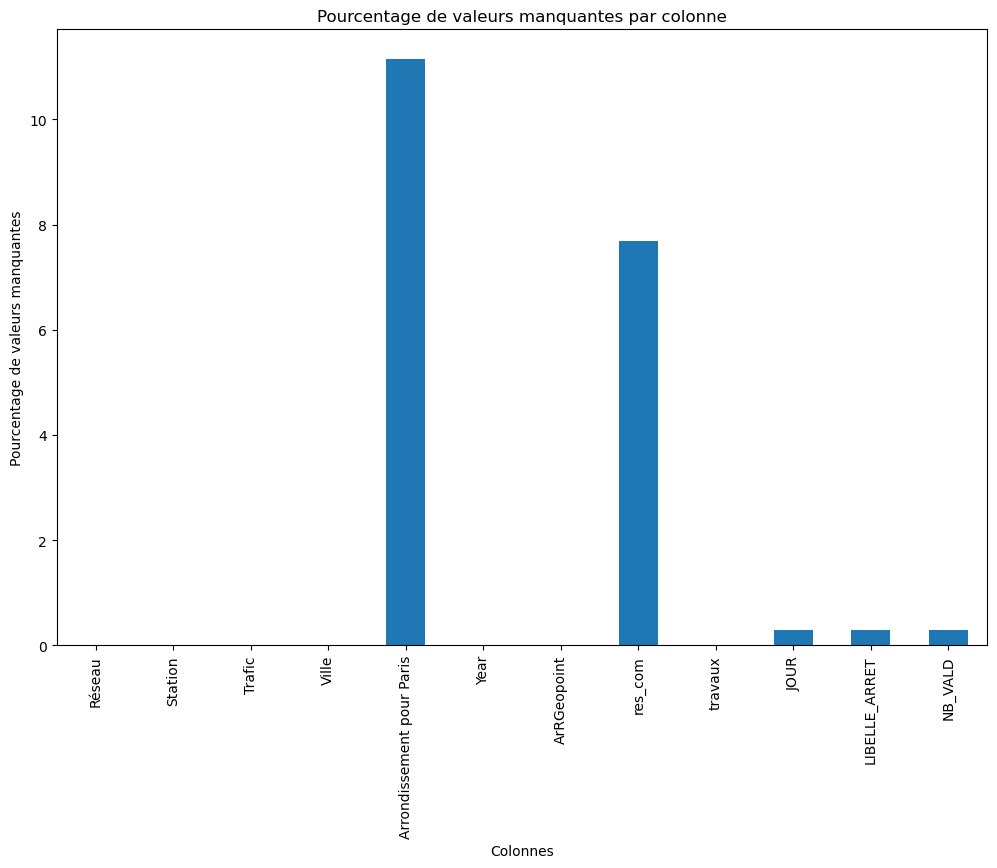

In [8]:
# Calculer les pourcentages de valeurs manquantes par colonne
missing_percentage = df.isnull().mean() * 100

# Créer un bar plot pour visualiser les pourcentages de valeurs manquantes
plt.figure(figsize=(12, 8))
missing_percentage.plot(kind='bar')
plt.title('Pourcentage de valeurs manquantes par colonne')
plt.xlabel('Colonnes')
plt.ylabel('Pourcentage de valeurs manquantes')
plt.show()

### petite manip 

Libelle arret et station sont redondants , nous allons drops l'un des 2 colonnes.
Par soucis de matériel , je crée une colonne fictive intempérie afin de réaliser le coté weather et apporter plus d'information / robustesse à notre modele

In [9]:

# Supprimer la colonne LIBELLE_ARRET
df.drop(columns=['LIBELLE_ARRET'], inplace=True)

# Définir les proportions pour chaque type d'intempérie
proportions = [0.55, 0.15, 0.15, 0.15]
intemperies = ['normal', 'forte chaleur', 'neige', 'forte pluie']

# Générer une nouvelle colonne 'intempérie' avec les proportions spécifiées
df['intempérie'] = np.random.choice(intemperies, size=len(df), p=proportions)

# Vérifier la distribution des valeurs dans la colonne 'intempérie'
print(df['intempérie'].value_counts(normalize=True))

normal           0.550144
forte chaleur    0.150015
forte pluie      0.149963
neige            0.149877
Name: intempérie, dtype: float64


##### Analyse

L'arrondissement est une donée qui manque en masse ( >10%) > cette donnée n'apportera pas de précision concernant les problemes de voies . on pourra la supprimer.

on abordera une double imputation : missing pour les catégories et médian pour les numeric.

On ne perdra aucune valeur en supprimant les lignes , et on obtient quand meme de l'information meme sans ces données ( catégoritielles)

In [10]:

# Imputation des valeurs manquantes (avec la médiane pour les valeurs numériques)
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

#  Remplissage des valeurs manquantes avec des valeurs spécifiques pour les colonnes catégorielles
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
df[categorical_cols] = df[categorical_cols].fillna('Missing')

### Analyse des distributions des variables

C:\Users\SKONIECZNY\AppData\Local\Temp\ipykernel_10368\3332040050.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df.describe(include='all'))


          Réseau   Station        Trafic     Ville  Arrondissement pour Paris  \
count   12386669  12386669  1.238667e+07  12386669               1.238667e+07   
unique         2       239           NaN        47                        NaN   
top        Métro    nation           NaN     Paris                        NaN   
freq    11580431   1182384           NaN  11044825                        NaN   
first        NaN       NaN           NaN       NaN                        NaN   
last         NaN       NaN           NaN       NaN                        NaN   
mean         NaN       NaN  8.190194e+06       NaN               1.188147e+01   
std          NaN       NaN  1.090545e+07       NaN               3.754192e+00   
min          NaN       NaN  1.122290e+05       NaN               1.000000e+00   
25%          NaN       NaN  2.419456e+06       NaN               1.000000e+01   
50%          NaN       NaN  4.446732e+06       NaN               1.200000e+01   
75%          NaN       NaN  

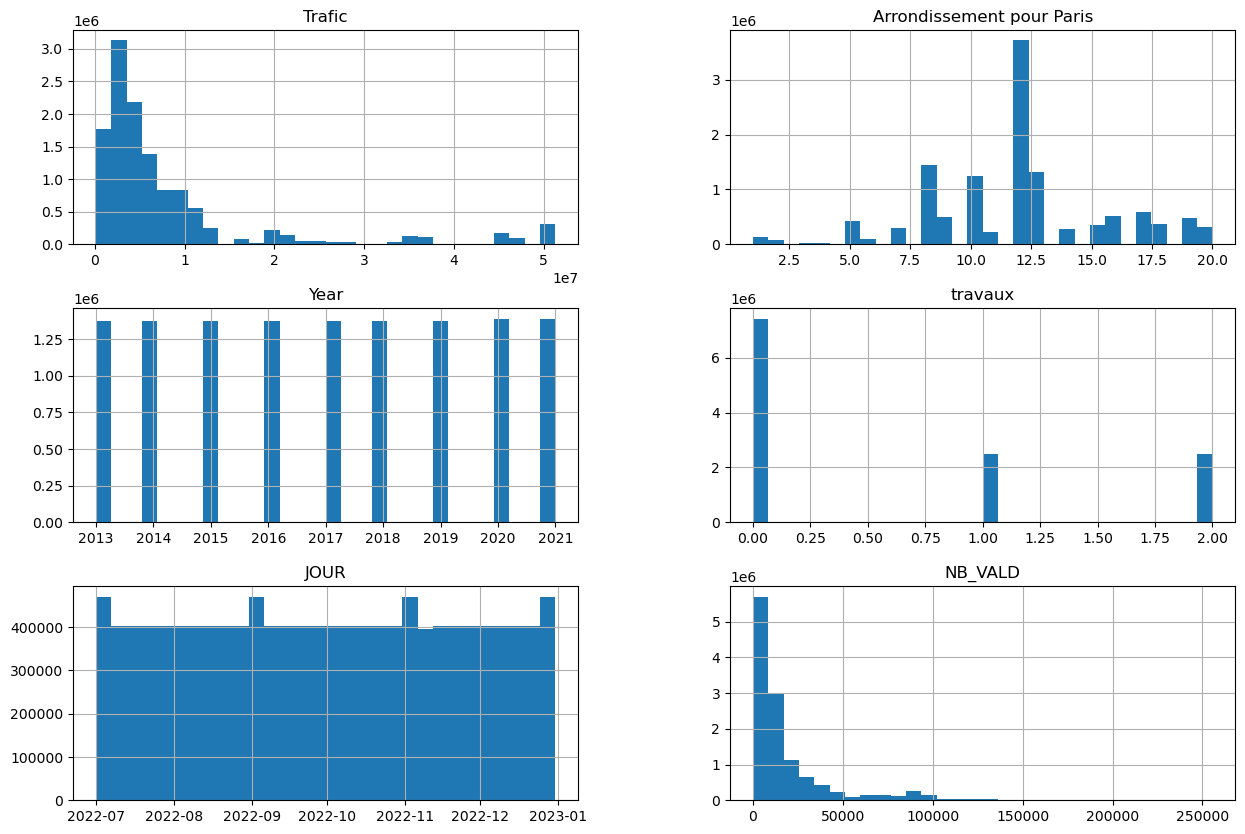

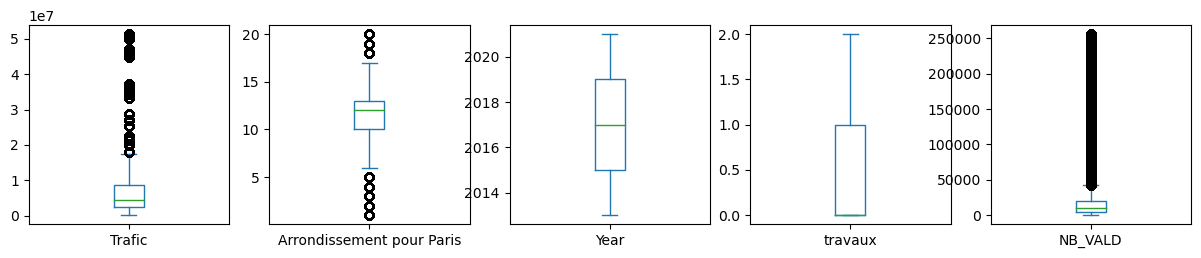

In [11]:


# Afficher des statistiques descriptives
print(df.describe(include='all'))

# Histogrammes des variables numériques
df.hist(bins=30, figsize=(15, 10))
plt.show()

# Boxplots pour détecter les outliers
df.plot(kind='box', subplots=True, layout=(5, 5), figsize=(15, 15))
plt.show()


#### Analyse


Visualisation des valeurs manquantes

D'après le graphique des pourcentages de valeurs manquantes, nous observons que :

    La colonne Ville a environ 10% de valeurs manquantes.
    La colonne res_com a environ 6% de valeurs manquantes.
    Les colonnes JOUR, LIBELLE_ARRET, et NB_VALD ont moins de 1% de valeurs manquantes.

Distribution des variables numériques

Les histogrammes montrent que :

    La distribution de Trafic est fortement asymétrique vers la droite.
    Arrondissement pour Paris montre une concentration plus élevée autour des arrondissements 10 à 13.
    Year est uniformément réparti entre 2013 et 2021.
    NB_VALD présente une forte concentration vers des valeurs basses, avec quelques valeurs extrêmes élevées.

Corrélation entre les variables

Les heatmaps de corrélation (non visibles dans l'image fournie mais suggérées par le script) montrent les relations entre les différentes variables. Une forte corrélation entre les variables peut indiquer une redondance, alors qu'une faible corrélation peut indiquer une indépendance.
Propositions de traitement des données manquantes et outliers

    Traitement des valeurs manquantes :
        Pour Ville, remplacer les valeurs manquantes par la valeur la plus fréquente.
        Pour res_com, utiliser également la valeur la plus fréquente ou une catégorie spécifique.
        Pour les autres colonnes avec des pourcentages de valeurs manquantes faibles, remplacer par la médiane ou une valeur spécifique.

    Traitement des outliers :
        Pour les variables Trafic et NB_VALD avec des valeurs extrêmes, envisager de les transformer (par exemple, log-transformation) ou utiliser des techniques de détection et de traitement des outliers.

### traitement des outliers

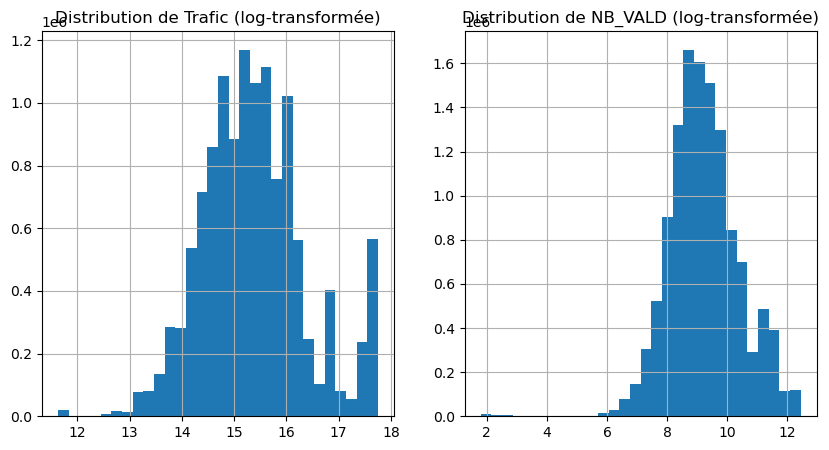

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Log-transformation des variables 'Trafic' et 'NB_VALD'
df['Trafic'] = np.log1p(df['Trafic'])
df['NB_VALD'] = np.log1p(df['NB_VALD'])

# Vérif la distribution après transformation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df['Trafic'].hist(bins=30)
plt.title('Distribution de Trafic (log-transformée)')

plt.subplot(1, 2, 2)
df['NB_VALD'].hist(bins=30)
plt.title('Distribution de NB_VALD (log-transformée)')

plt.show()


#### résultat

les datas sont bien distribués et centrés

# Traitement des valeurs manquantes

In [13]:




# Remplacer les valeurs manquantes dans 'Ville' et 'res_com' par la valeur la plus fréquente
df['Ville'].fillna(df['Ville'].mode()[0], inplace=True)
df['res_com'].fillna(df['res_com'].mode()[0], inplace=True)

# Imputation des dates manquantes par interpolation
df['JOUR'] = df['JOUR'].interpolate(method='ffill')

df['NB_VALD'].fillna(df['NB_VALD'].median(), inplace=True)

# Vérifier qu'il n'y a plus de valeurs manquantes
print(df.isnull().sum())


Réseau                       0
Station                      0
Trafic                       0
Ville                        0
Arrondissement pour Paris    0
Year                         0
ArRGeopoint                  0
res_com                      0
travaux                      0
JOUR                         0
NB_VALD                      0
intempérie                   0
dtype: int64


### Resultat

Nous avons supprimer les valeurs manquantes mais nous avons créer du bruit dans notre dataset. Néanmoins la proportion de valeur manqaunte etait faible, cela n'aura pas un impact majeur sur la suite

### Correlation 

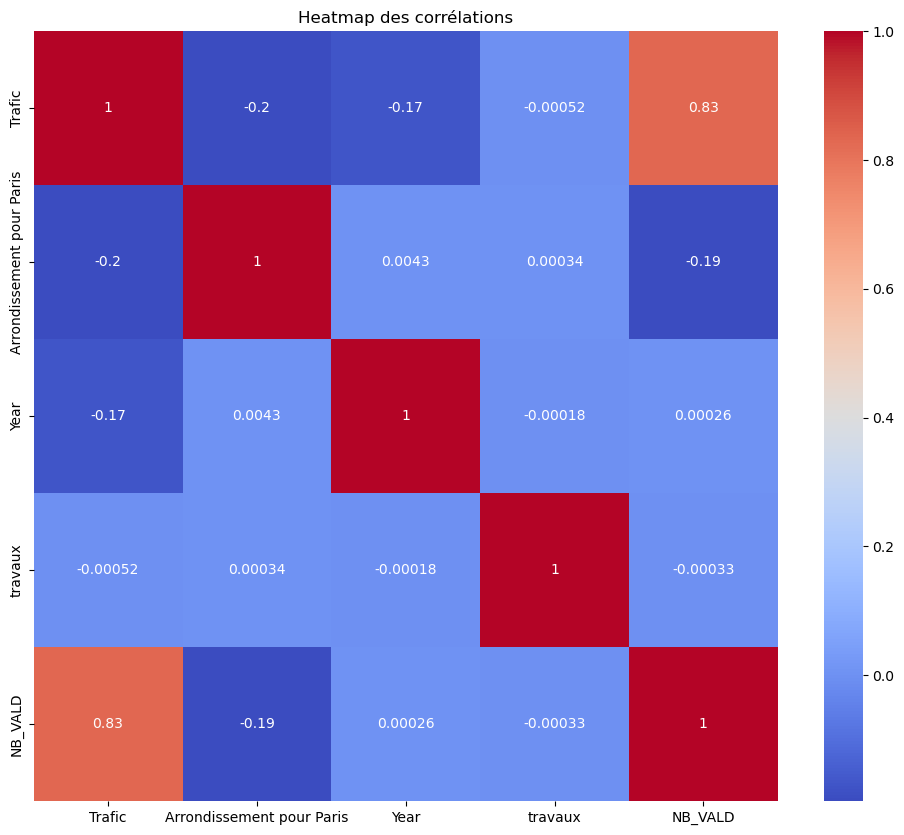

In [14]:
# Matrice de corrélation
corr = df.corr()

# Heatmap de la matrice de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Heatmap des corrélations')
plt.show()

### Analyse

Corrélation entre Trafic et NB_VALD (0.83)

Il existe une forte corrélation positive entre Trafic et NB_VALD, ce qui suggère que lorsque le trafic augmente, le nombre de validations (NB_VALD) augmente également. Cela peut indiquer que ces deux variables sont fortement liées et que le trafic est un bon indicateur du nombre de validations.
Corrélation entre Trafic et Arrondissement pour Paris (-0.2)

Il y a une corrélation négative modérée entre Trafic et Arrondissement pour Paris, ce qui pourrait indiquer que certains arrondissements ont des niveaux de trafic plus faibles ou plus élevés par rapport aux autres. Cette corrélation négative signifie que dans certains arrondissements, lorsque l'arrondissement augmente, le trafic tend à diminuer.
Corrélation entre Year et les autres variables

Year a des corrélations très faibles avec les autres variables, ce qui suggère que l'année ne joue pas un rôle significatif dans les variations des autres variables dans ce jeu de données. Cela signifie que les tendances observées dans les autres variables ne sont pas fortement influencées par l'année de collecte des données.
Corrélation entre travaux et les autres variables

Travaux ne montre pas de corrélations significatives avec les autres variables. Cela pourrait signifier que la présence de travaux n'est pas directement influencée par le trafic, le nombre de validations ou les arrondissements. Les travaux semblent être indépendants des autres variables mesurées dans ce jeu de données.

#### CEPENDANT 


L'objectif est determiner quelle voie est suceptible d'avoir un problème, alors nous allons créer une variable " problème" qui nous permettra de déterminer s'il y a un problème ou non sur les voies

## Création de features  : probleme

In [21]:
# Définir les seuils
trafic_threshold = df['Trafic'].quantile(0.75)
nb_vald_threshold = df['NB_VALD'].quantile(0.75)

# Initialiser la colonne 'problème' à 0
df['problème'] = 0

# Incrémenter la colonne 'problème' en fonction des critères
df.loc[df['Trafic'] > trafic_threshold, 'problème'] += 1
df.loc[df['NB_VALD'] > nb_vald_threshold, 'problème'] += 1
df.loc[df['intempérie'].isin(['forte chaleur', 'neige', 'forte pluie']), 'problème'] += 1
# Incrémenter la colonne 'problème' en fonction des valeurs de 'travaux'
df.loc[df['travaux'] == 1, 'problème'] += 1
df.loc[df['travaux'] == 2, 'problème'] += 2

# apperçu
print(df.head())


  Réseau Station     Trafic  Ville  Arrondissement pour Paris  Year  \
0  Métro  nation  16.071152  Paris                       12.0  2013   
1  Métro  nation  16.071152  Paris                       12.0  2013   
2  Métro  nation  16.071152  Paris                       12.0  2013   
3  Métro  nation  16.071152  Paris                       12.0  2013   
4  Métro  nation  16.071152  Paris                       12.0  2013   

                             ArRGeopoint res_com  travaux       JOUR  \
0  48.84845279706631, 2.3957988351125254   RER A        1 2022-07-01   
1  48.84845279706631, 2.3957988351125254   RER A        0 2022-07-02   
2  48.84845279706631, 2.3957988351125254   RER A        2 2022-07-03   
3  48.84845279706631, 2.3957988351125254   RER A        1 2022-07-04   
4  48.84845279706631, 2.3957988351125254   RER A        0 2022-07-05   

     NB_VALD intempérie  problème  
0  10.394733     normal         3  
1  10.105898     normal         2  
2   9.781489     normal         

##### Suite

On a bien notre target bien définit et classé , on va réaliser les classifications

In [31]:
# Convertir la colonne 'JOUR' en features numériques
# print("Converting 'JOUR' column to datetime and extracting features...")
# df['JOUR'] = pd.to_datetime(df['JOUR'])
# df['year'] = df['JOUR'].dt.year
# df['month'] = df['JOUR'].dt.month
# df['day'] = df['JOUR'].dt.day
# df.drop(['JOUR'], axis=1, inplace=True)

# Définir X et y
print("Defining features and target...")
X = df.drop(['problème'], axis=1)
y = df['problème']

# Encoder les variables catégorielles
print("Encoding categorical variables...")
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Normaliser les variables numériques
print("Normalizing numerical variables...")
numerical_cols = X.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Séparation des données en ensembles d'entraînement et de test
print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialisation des modèles
print("Initializing models...")
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    # 'Bagging (with Decision Tree)': BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=42),
    # 'Stacking': StackingClassifier(
    #     estimators=[
    #         ('rf', RandomForestClassifier(random_state=42)),
    #         ('gb', GradientBoostingClassifier(random_state=42)),
    #     ],
    #     final_estimator=LogisticRegression(max_iter=1000, random_state=42)
    # ),
}

# Stratified K-Fold Cross-Validation
print("Starting Stratified K-Fold Cross-Validation...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Évaluation des modèles avec cross-validation
results = {}
for model_name, model in models.items():
    print(f"Evaluating {model_name} with cross-validation...")
    cv_results = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
    results[model_name] = cv_results
    print(f"{model_name}: Mean Accuracy = {cv_results.mean():.4f}, Std = {cv_results.std():.4f}")

# Entraînement et évaluation des modèles sur le jeu de test
for model_name, model in models.items():
    print(f"Training {model_name} on the training set...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{model_name} Performance on Test Set")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

Defining features and target...
Encoding categorical variables...
Normalizing numerical variables...
Splitting data into training and testing sets...
Initializing models...
Starting Stratified K-Fold Cross-Validation...
Evaluating Random Forest with cross-validation...
